# Компьютерное зрение и OpenCV


[OpenCV](https://opencv.org/) является *де-факто* стандартом для обработки изображений. Эта библиотека содержит множество полезных алгоритмов, реализованных на C++, которые Вы также можете вызывать из Python.

Мы приведем несколько примеров использования OpenCV. Для получения более подробной информации рекомендуем изучить онлайн-курс [Learn OpenCV](https://learnopencv.com/getting-started-with-opencv/) (на англ). 

Для начала, импортируем OpenCV, а также некоторые другие полезные библиотеки.

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

cv2.__version__

'4.6.0'

Обратите внимание, что, несмотря на название `cv2`, мы на самом деле используем версию 4 библиотеки.

Также опишем удобную функцию `display_images`, которая использует matplotlib для отображения сразу нескольких картинок из заданного списка.

In [3]:

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()


## Загрузка изображений

Изображения в Python могут быть удобно представлены массивами NumPy. Например, изображение в градациях серого размером 320x200 пикселей будет храниться в массиве 200x320, а цветное изображение того же размера - 200x320x3 (для 3 цветовых каналов). 

Начнем с загрузки изображения:

(242, 531, 3)


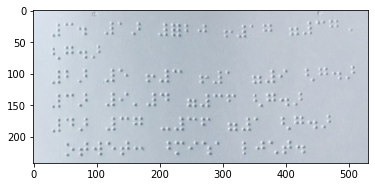

In [4]:
im = cv2.imread('data/braille.jpeg')
print(im.shape)
plt.imshow(im)

As you can see, it is an image of braille text. Since we are not very interested in the actual color, we can convert it to black-and-white:

Как видите, это изображение текста Брайля. Поскольку нас не очень интересует фактический цвет, мы можем преобразовать его в черно-белый:

(242, 531)


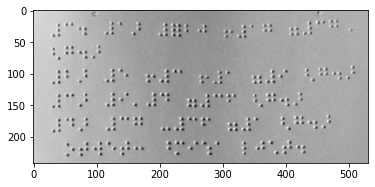

In [6]:
bw_im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
print(bw_im.shape)
plt.imshow(bw_im,cmap='gray')

## Обработка изображений Брайля

Если мы хотим научиться распознавать символы Брайля, то нам нужно будет использовать классификацию изображений для распознавания текста, как мы это ранее делали с датасетом MNIST. Это можно сделать с помощью нейросетевой модели *обнаружения объектов* (object detection) - и это мы обсудим позже. Но можно попробовать использовать для этого чистое компьютерное зрение.

Хорошее описание того, как компьютерное зрение может быть использовано для разделения символов, можно найти [в этом заметке](https://learnopencv.com/image-alignment-feature-based-using-opencv-c-python/) - здесь же мы сосредоточимся только на некоторых методах компьютерного зрения.

Во-первых, давайте попробуем немного улучшить изображение. Мы можем использовать идею **thresholding** (хорошо описана [в этой статье по OpenCV](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html)):

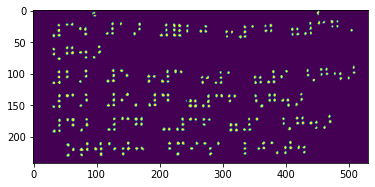

In [12]:
im = cv2.blur(bw_im,(3,3))
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                           cv2.THRESH_BINARY_INV, 5, 4)
im = cv2.medianBlur(im, 3)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
im = cv2.GaussianBlur(im, (3,3), 0)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
plt.imshow(im)

Для того, чтобы дальше работать с изображением, нам нужно получить координаты каких-то опорных точек. Для этого используются методы **извлечения признаков**, такие как SIFT, SURF или [ORB](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html). Мы не будем вдаваться в подробности, как работают эти методы - попробуем применить ORB для нашего сравнительно простого случая:

In [13]:
orb = cv2.ORB_create(5000)
f,d = orb.detectAndCompute(im,None)
print(f"Первые 5 точек: { [f[i].pt for i in range(5)]}")

Первые 5 точек: [(307.20001220703125, 40.80000305175781), (297.6000061035156, 114.00000762939453), (423.6000061035156, 133.20001220703125), (242.40000915527344, 144.0), (103.68000793457031, 57.60000228881836)]


Давайте построим все точки, чтобы убедиться, что они действительно соответствуют точкам в азбуке Брайля:

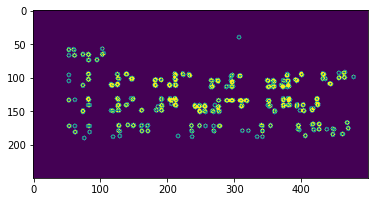

In [14]:
def plot_dots(dots):
    img = np.zeros((250,500))
    for x in dots:
        cv2.circle(img,(int(x[0]),int(x[1])),3,(255,0,0))
    plt.imshow(img)

pts = [x.pt for x in f]
plot_dots(pts)  

Чтобы разделить отдельные символы, нам нужно знать ограничительную рамку всего текста. Чтобы её найти, достаточно просто вычислить минимальные и максимальные координаты: 

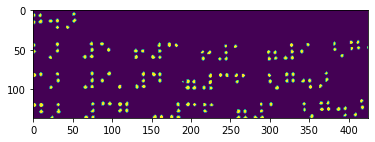

In [15]:
min_x, min_y, max_x, max_y = [int(f([z[i] for z in pts])) for f in (min,max) for i in (0,1)]
min_y+=13
plt.imshow(im[min_y:max_y,min_x:max_x])

Кроме того, этот текст может быть частично повернут, и чтобы сделать его идеально выровненным, нам нужно применить так называемое **преобразование перспективы**, или **гомографию**. Возьмем прямоугольник, определяемый точками $(x_{min},y_{min}), (x_{min},y_{max}), (x_{max},y_{min}), (x_{max},y_{max})$ и выровняем его с новым изображением с пропорциональными размерами:

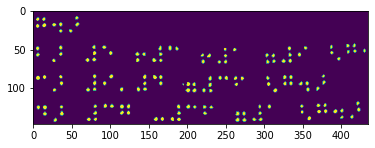

In [16]:
off = 5
src_pts = np.array([(min_x-off,min_y-off),(min_x-off,max_y+off),
                    (max_x+off,min_y-off),(max_x+off,max_y+off)])
w = int(max_x-min_x+off*2)
h = int(max_y-min_y+off*2)
dst_pts = np.array([(0,0),(0,h),(w,0),(w,h)])
ho,m = cv2.findHomography(src_pts,dst_pts)
trim = cv2.warpPerspective(im,ho,(w,h))
plt.imshow(trim)

После того, как мы получили хорошо выровненное изображение, можно разрезать его на части с помощью двойного цикла, подобрав значения ширины и высоты ячейки:

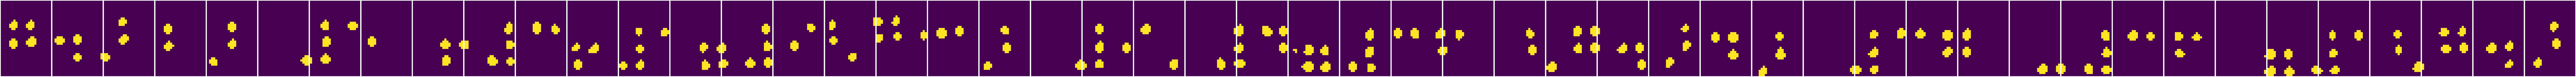

In [17]:
char_h = 36
char_w = 24
def slice(img):
    dy,dx = img.shape
    y = 0
    while y+char_h<dy:
        x=0
        while x+char_w<dx:
            # Skip empty lines
            if np.max(img[y:y+char_h,x:x+char_w])>0:
                yield img[y:y+char_h,x:x+char_w]
            x+=char_w
        y+=char_h

sliced = list(slice(trim))
display_images(sliced)

Теперь к полученным символам можно применять методы классификации изображений, про которые мы уже говорили и будем говорить в следующих разделах курса.

## Обнаружение движения с использованием разности кадров

Обнаружение движения в видеопотоке является очень частой задачей. Например, это позволяет нам получать оповещения, когда что-то происходит на камере наблюдения. Если мы хотим понять, что именно происходит на камере - мы можем использовать нейронную сеть для обнаружения объектов, но применять её к одним и тем же кадрам, на которых ничего не происходит - накладно.

Основная идея обнаружения движения проста. Если камера фиксирована, то кадры с камеры должны быть очень похожи друг на друга. Поскольку кадры представлены в виде массивов, просто вычитая эти массивы для двух последующих кадров мы получим массив разности пикселей. Значения в таком массиве должны быть небольшими для статических кадров и становиться больше, как только в изображении происходит существенное изменение.

Мы начнем с того, что узнаем, как открыть видео и преобразовать его в последовательность кадров:  

Total frames: 876


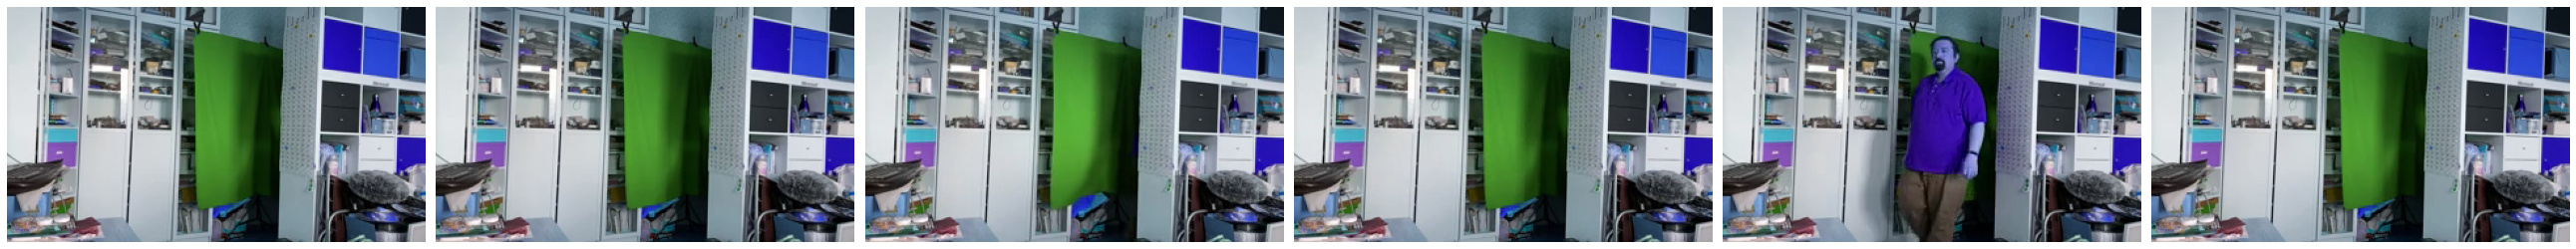

In [18]:
vid = cv2.VideoCapture('data/motionvideo.mp4')

c = 0
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
    c+=1
vid.release()
print(f"Total frames: {c}")
display_images(frames[::150])

Поскольку цвет не так важен для обнаружения движения, мы преобразуем все кадры в оттенки серого. Затем мы вычислим разность между кадрами и построим их нормы, чтобы визуально увидеть объем происходящей активности: 

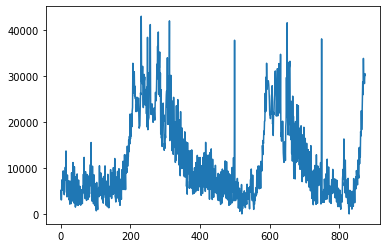

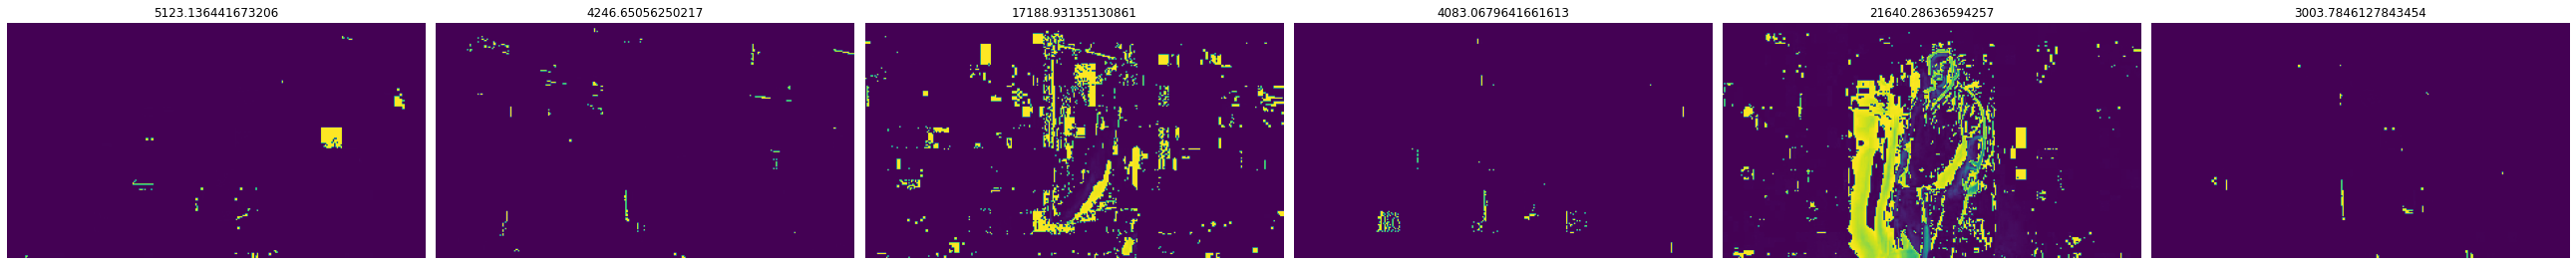

In [19]:
bwframes = [cv2.cvtColor(x,cv2.COLOR_BGR2GRAY) for x in frames]
diffs = [(p2-p1) for p1,p2 in zip(bwframes[:-1],bwframes[1:])]
diff_amps = np.array([np.linalg.norm(x) for x in diffs])
plt.plot(diff_amps)
display_images(diffs[::150],titles=diff_amps[::150])

Предположим, мы хотим создать отчет, который показывает все необычные события, происходящие перед камерой. Для этого мы, вероятно, захотим узнать начальный и конечный кадр «события» и отобразить средний кадр из него. Чтобы удалить некоторый шум, сгладим кривую выше с помощью скользящего среднего: 

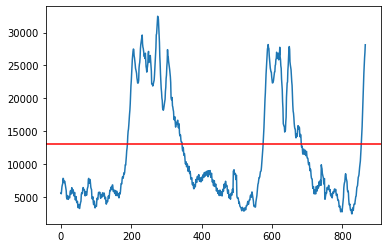

In [20]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

threshold = 13000

plt.plot(moving_average(diff_amps,10))
plt.axhline(y=threshold, color='r', linestyle='-')

Теперь мы можем найти кадры, которые имеют количество изменений выше порога, используя 'np.where', и извлечь последовательности идущих подряд кадров, которые длиннее заданного количества кадров: 

In [21]:
active_frames = np.where(diff_amps>threshold)[0]
print(active_frames)


def subsequences(seq,min_length=30):
    ss = []
    for i,x in enumerate(seq[:-1]):
        ss.append(x)
        if x+1 != seq[i+1]:
            if len(ss)>min_length:
                yield ss.copy()
            ss.clear()
    if len(ss)>min_length:
        yield ss

seqs = list(subsequences(active_frames,20))
seqs

[ 15  87 191 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209
 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299
 300 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317
 318 319 320 321 322 324 325 326 327 328 330 332 334 335 336 337 338 340
 342 344 348 352 356 360 364 368 372 376 412 416 428 432 499 579 581 582
 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600
 601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618
 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636
 637 638 639 642 643 644 646 647 648 649 650 651 652 653 654 655 656 657
 658 659 660 661 662 663 664 666 667 668 670 672 67

[[195,
  196,
  197,
  198,
  199,
  200,
  201,
  202,
  203,
  204,
  205,
  206,
  207,
  208,
  209,
  210,
  211,
  212,
  213,
  214,
  215,
  216,
  217,
  218,
  219,
  220,
  221,
  222,
  223,
  224,
  225,
  226,
  227,
  228,
  229,
  230,
  231,
  232,
  233,
  234,
  235,
  236,
  237,
  238,
  239,
  240,
  241,
  242,
  243,
  244,
  245,
  246,
  247,
  248,
  249,
  250,
  251,
  252,
  253,
  254,
  255,
  256,
  257,
  258,
  259,
  260,
  261,
  262,
  263,
  264,
  265,
  266,
  267,
  268,
  269,
  270,
  271,
  272,
  273,
  274,
  275,
  276,
  277,
  278,
  279,
  280,
  281,
  282,
  283,
  284,
  285,
  286,
  287,
  288,
  289,
  290,
  291,
  292,
  293,
  294,
  295,
  296,
  297,
  298,
  299,
  300,
  301,
  302,
  303,
  304,
  305,
  306,
  307,
  308,
  309,
  310,
  311,
  312,
  313,
  314,
  315,
  316,
  317,
  318,
  319,
  320,
  321,
  322],
 [581,
  582,
  583,
  584,
  585,
  586,
  587,
  588,
  589,
  590,
  591,
  592,
  593,
  594,
  595

Отобразим середину каждого из полученных интервалов:

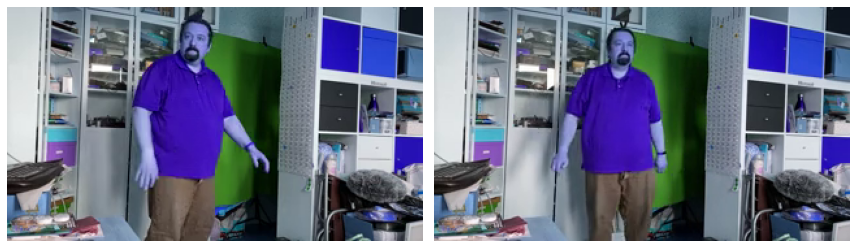

In [22]:
display_images([frames[(s[0]+s[-1])//2] for s in seqs])

Вы можете заметить, что цветовая гамма на этом изображении выглядит неправильно! Это связано с тем, что OpenCV по историческим причинам загружает изображения в цветовое пространство BGR, в то время как matplotlib использует более традиционный цветовой порядок RGB. В большинстве случаев имеет смысл конвертировать изображения в RGB сразу после их загрузки. 

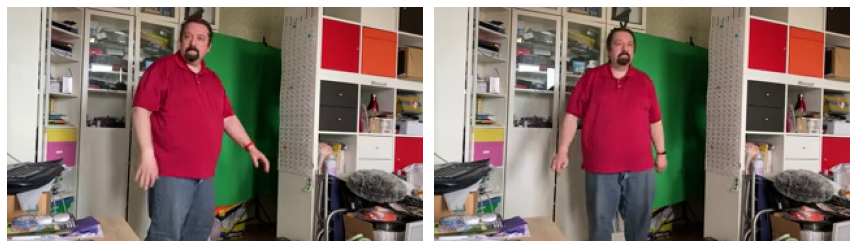

In [23]:
frames_rgb = [cv2.cvtColor(x,cv2.COLOR_BGR2RGB) for x in frames]
display_images([frames_rgb[(s[0]+s[-1])//2] for s in seqs])

## Извлечение движения с помощью оптического потока

Простое сравнение двух последовательных кадров позволяет нам увидеть количество изменений, но оно не дает никакой информации о том, что на самом деле движется в кадре, где и в какую сторону. Для получения этой информации существует метод, называемый **[оптический поток](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html)** (*optical flow*):

* **Плотный оптический поток** вычисляет векторное поле, которое показывает для каждого пикселя, в каком направлении и с какой интенсивностью он движется
* **Разреженный оптический поток** основан на взятии некоторых отличительных особенностей на изображении (например, краев) и построении их траектории от кадра к кадру.

Подробнее об оптическом потоке вы можете узнать [в этой замечательной статье из учебника по OpenCV](https://learnopencv.com/optical-flow-in-opencv/), а про разницу в методах поиска оптического потока - [в этой статье](https://habr.com/ru/post/201406).

Рассмотрим, как вычисляется плотный оптический поток. Обозначим через $I(x,y,t)$ яркость пикселя с координатами $(x,y)$ в момент времени $t$. Предположим, что в момент времени $t+\delta t$ пиксель переместился на вектор $(\delta x,\delta y)$, т.е. $I(x,y,t)\approx I(x+\delta x,y+\delta y, t+\delta t)$.

Для небольших смещений, можем использовать разложение в ряд Тейлора:

$$
I(x+\delta x,y+\delta y, t+\delta t) \approx I(x,y,t) + {\partial I\over\partial x}\delta x + {\partial I\over\partial y}\delta y + {\partial I\over\partial t}\delta t 
$$

Отсюда для перемещенных пикселей получаем уравнение:

$${\partial I\over\partial x}\delta x + {\partial I\over\partial y}\delta y + {\partial I\over\partial t}\delta t = 0$$

Учитывая, что ${\delta x\over\delta t} = V_x$ - это скорость перемещения пискеля по оси $x$ (и аналогично для $y$), получаем

$${\partial I\over\partial x}V_x + {\partial I\over\partial y}V_y + {\partial I\over\partial t} = 0$$


Давайте вычислим плотный оптический поток между нашими кадрами:

In [24]:
flows = [cv2.calcOpticalFlowFarneback(f1, f2, None, 0.5, 3, 15, 3, 5, 1.2, 0) 
         for f1,f2 in zip(bwframes[:-1],bwframes[1:])]
flows[0].shape

(180, 320, 2)

Как видно, для каждого кадра полученный поток имеет размеры кадра, и 2 канала, соответствующие x и y компонентам вектора оптического потока ($V_x$ и $V_y$).

Чтобы отобразить оптический поток на плоскости, мы можем использовать такой хитрый приём: переведём декартовы координаты в полярные. При этом мы получим две составляющие для каждого пикселя: *направление* и *интенсивность*. Мы можем представить интенсивность яркостью пикселей, а направление - разными оттенками цвета. Таким образом, мы получим изображение в [цветовом пространстве HSV (Hue-Saturation-Value)](https://en.wikipedia.org/wiki/HSV_color_space), где оттенок будет определяться направлением, значение - интенсивностью, а насыщенность будет 255. 

195 322


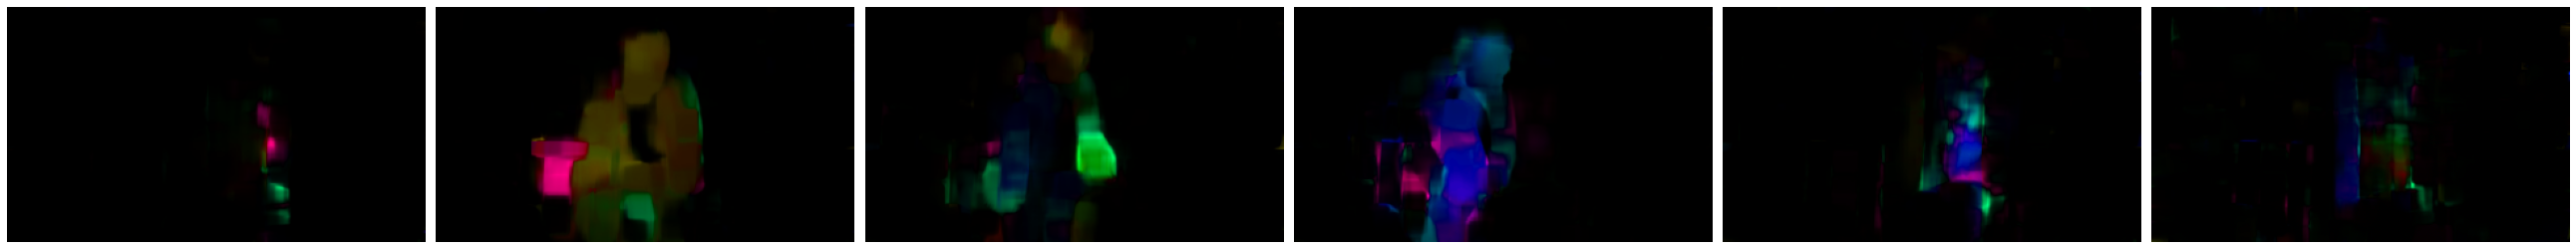

In [25]:
def flow_to_hsv(flow):
    hsvImg = np.zeros((flow.shape[0],flow.shape[1],3),dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsvImg[..., 0] = 0.5 * ang * 180 / np.pi
    hsvImg[..., 1] = 255
    hsvImg[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    return cv2.cvtColor(hsvImg, cv2.COLOR_HSV2BGR)

start = seqs[0][0]
stop = seqs[0][-1]
print(start,stop)

frms = [flow_to_hsv(x) for x in flows[start:stop]]
display_images(frms[::25])

В этих кадрах один цвет соответствует движению влево, а другой – движению вправо.

Оптический поток может стать отличным инструментом для того, чтобы сделать выводы об общем направлении движения. Например, если вы видите, что все пиксели в кадре движутся более-менее в одном направлении – можно сделать вывод, что есть движение камеры, и попытаться компенсировать это.

## Выводы

Вы видели, что довольно много задач можно выполнить, используя чистую обработку изображений, без какого-либо искусственного интеллекта. Если мы сможем использовать методы компьютерного зрения, чтобы упростить работу нейронной сети – мы обязательно должны это сделать, потому что это позволит нам решать задачи с меньшим количеством обучающих данных.